Tamaños:  (700, 2) (300, 2)
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejor params: {'metric': 'euclidean', 'n_neighbors': 21, 'weights': 'uniform'}
Mejor score CV: 0.9242857142857144
KNN (best) -> acc: 0.9567 | fit_time: 0.001s | pred_time: 0.0040s
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       143
           1       0.94      0.97      0.96       157

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300



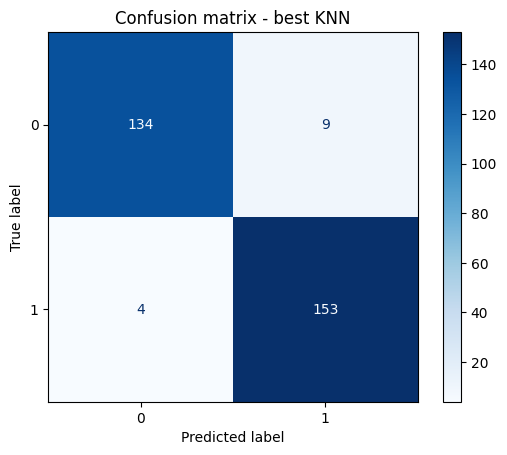

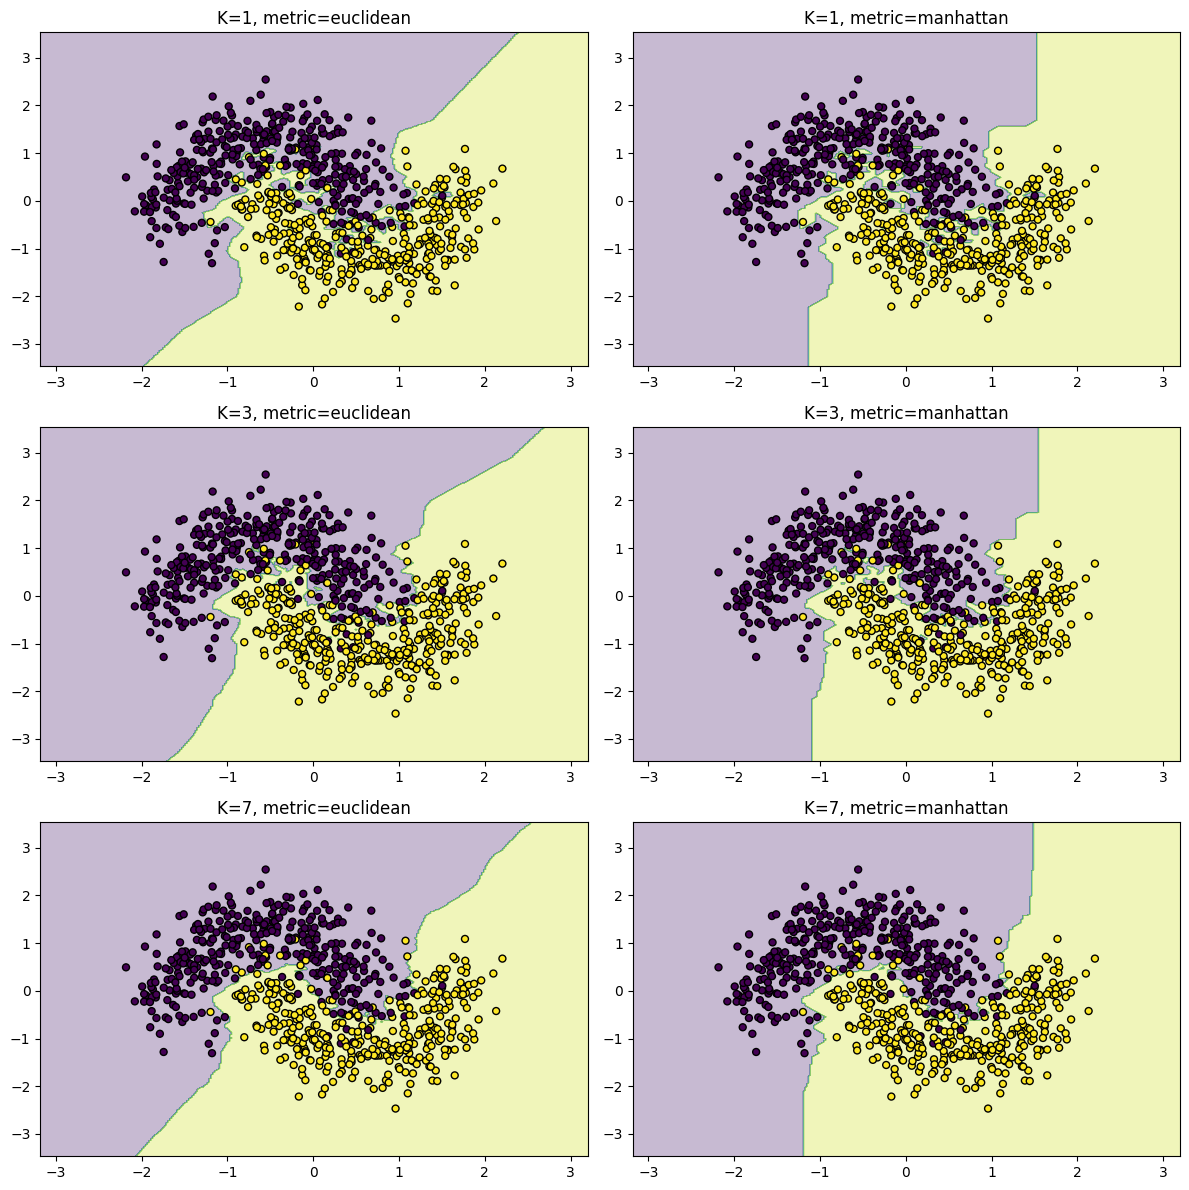

Brute-force time for 200 queries: 0.039s
Accuracy (brute-force subset vs scikit): 0.935
sklearn predict time (full test): 0.0044s
brute-force predict time (full test): 0.0378s
sklearn acc: 0.9566666666666667  brute-force acc: 0.9566666666666667
=== Conclusiones del experimento ===
- K-NN es sensible al escalado: siempre escalar antes de usar.
- Elección de K: valores pequeños -> fronteras complejas; valores grandes -> fronteras suaves.
- Métrica importa: Euclidiana vs Manhattan pueden producir diferencias importantes.
- Rendimiento: versión brute-force es O(n_train) por consulta; scikit-learn usa estructuras que aceleran búsqueda en muchos casos (BallTree/KDTree).


In [2]:
# === Celda 1: importaciones ===
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_moons, make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle

# === Celda 2: funciones utilitarias ===
def plot_decision_boundary(clf, X, y, title="Decision boundary", ax=None, mesh_step=0.02):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))
    x_min, x_max = X[:,0].min() - 1, X[:,0].max() + 1
    y_min, y_max = X[:,1].min() - 1, X[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step),
                         np.arange(y_min, y_max, mesh_step))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.3)
    scatter = ax.scatter(X[:,0], X[:,1], c=y, s=25, edgecolor='k')
    ax.set_title(title)
    return ax

def evaluate_and_show(clf, X_train, X_test, y_train, y_test, name="Model"):
    t0 = time.time()
    clf.fit(X_train, y_train)
    fit_time = time.time() - t0
    t1 = time.time()
    y_pred = clf.predict(X_test)
    pred_time = time.time() - t1
    acc = accuracy_score(y_test, y_pred)
    print(f"{name} -> acc: {acc:.4f} | fit_time: {fit_time:.3f}s | pred_time: {pred_time:.4f}s")
    print(classification_report(y_test, y_pred))
    return acc, fit_time, pred_time, y_pred

# === Celda 3: Generar dataset sintético y escalar ===
# Usaremos make_moons (2D, no lineal) y make_classification (multidim) si se desea
X, y = make_moons(n_samples=1000, noise=0.25, random_state=0)
X, y = shuffle(X, y, random_state=0)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Escalado (crucial para K-NN)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Tamaños: ", X_train.shape, X_test.shape)

# === Celda 4: Experimentos con K y métricas (Grid search simple) ===
param_grid = {
    'n_neighbors': [1, 3, 5, 7, 11, 21],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

knn = KNeighborsClassifier()
gs = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
gs.fit(X_train, y_train)
print("Mejor params:", gs.best_params_)
print("Mejor score CV:", gs.best_score_)
best_knn = gs.best_estimator_


# === Celda 5: Evaluar mejor modelo sobre test y mostrar matriz de confusión ===
acc, fit_t, pred_t, y_pred = evaluate_and_show(best_knn, X_train, X_test, y_train, y_test, name="KNN (best)")
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred))
disp.plot(cmap='Blues')
plt.title("Confusion matrix - best KNN")
plt.show()

# === Celda 6: Visualizar fronteras de decisión para varios K y métricas ===
Ks = [1, 3, 7]
metrics = ['euclidean', 'manhattan']
# The problematic lines are removed, keeping only the correct plotting block
fig, axes = plt.subplots(len(Ks), len(metrics), figsize=(12, 4*len(Ks)))
for i, K in enumerate(Ks):
    for j, metric in enumerate(metrics):
        clf = KNeighborsClassifier(n_neighbors=K, weights='uniform', metric=metric)
        clf.fit(X_train, y_train)
        plot_decision_boundary(clf, X_train, y_train, title=f"K={K}, metric={metric}", ax=axes[i,j])
plt.tight_layout()
plt.show()


# === Celda 7: Comparación con implementación educativa brute-force (para entender el algoritmo) ===
# Brute-force K-NN predict for small test sets (educational; not optimized)
def brute_force_knn_predict(X_train, y_train, X_query, K=3, metric='euclidean', weight='uniform'):
    # metric: 'euclidean' or 'manhattan' or 'minkowski'
    y_pred = []
    for xq in X_query:
        if metric == 'euclidean':
            dists = np.linalg.norm(X_train - xq, axis=1)
        elif metric == 'manhattan':
            dists = np.sum(np.abs(X_train - xq), axis=1)
        else:
            # default minkowski p=3
            p = 3
            dists = np.sum(np.abs(X_train - xq)**p, axis=1)**(1/p)
        idx = np.argsort(dists)[:K]
        neigh_labels = y_train[idx]
        if weight == 'uniform':
            # majority vote
            vals, counts = np.unique(neigh_labels, return_counts=True)
            y_pred.append(vals[np.argmax(counts)])
        else:
            # distance weighting: sum of weights per class (weight = 1/d)
            weights = 1.0 / (dists[idx] + 1e-9)
            classes = {}
            for lab, w in zip(neigh_labels, weights):
                classes[lab] = classes.get(lab, 0) + w
            # choose class with max total weight
            y_pred.append(max(classes.items(), key=lambda kv: kv[1])[0])
    return np.array(y_pred)

# Test brute-force on a small subset to measure time
Xq = X_test[:200]
t0 = time.time()
ybf = brute_force_knn_predict(X_train, y_train, Xq, K=5, metric='euclidean', weight='uniform')
t1 = time.time()
print("Brute-force time for 200 queries: {:.3f}s".format(t1 - t0))
print("Accuracy (brute-force subset vs scikit):", accuracy_score(y_test[:200], ybf))


# === Celda 8: Benchmark de tiempos (scikit-learn vs brute force) ===
# time prediction for full test set
clf_sk = KNeighborsClassifier(n_neighbors=gs.best_params_['n_neighbors'],
                              weights=gs.best_params_['weights'],
                              metric=gs.best_params_['metric'])
clf_sk.fit(X_train, y_train)
t0 = time.time(); y_sk = clf_sk.predict(X_test); t1 = time.time()
print("sklearn predict time (full test): {:.4f}s".format(t1 - t0))

t0 = time.time(); y_bf = brute_force_knn_predict(X_train, y_train, X_test, K=gs.best_params_['n_neighbors'],
                                               metric=gs.best_params_['metric'], weight=gs.best_params_['weights'])
t1 = time.time()
print("brute-force predict time (full test): {:.4f}s".format(t1 - t0))

print("sklearn acc:", accuracy_score(y_test, y_sk), " brute-force acc:", accuracy_score(y_test, y_bf))


# === Celda 9: Conclusions printed ===
print("=== Conclusiones del experimento ===")
print("- K-NN es sensible al escalado: siempre escalar antes de usar.")
print("- Elección de K: valores pequeños -> fronteras complejas; valores grandes -> fronteras suaves.")
print("- Métrica importa: Euclidiana vs Manhattan pueden producir diferencias importantes.")
print("- Rendimiento: versión brute-force es O(n_train) por consulta; scikit-learn usa estructuras que aceleran búsqueda en muchos casos (BallTree/KDTree).")
